In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/lukemia"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/lukemia

/content/drive/MyDrive/lukemia


In [ ]:
!pwd

/content/drive/MyDrive/lukemia


In [ ]:
!kaggle datasets download -d andrewmvd/leukemia-classification

leukemia-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!du -hs /content/drive/MyDrive/lukemia

11G	/content/drive/MyDrive/lukemia


In [ ]:
!ls

C-NMC_Leukemia	kaggle.json  leukemia-classification.zip  models


In [ ]:
!unzip leukemia-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_6_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_7_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_1_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_2_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_3_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_1_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_2_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_3_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_4_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_5_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_6_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_7_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/

In [ ]:
!pwd

/content/drive/MyDrive/lukemia


In [ ]:
!pip install tensorflow

     |████████████████████████████████| 462 kB 8.5 MB/s 


# Importing required libraries

In [ ]:
import numpy as np  #to word with images and tensors
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import os
import tqdm # to keep track of callbacks and progress bars
import skimage.io # use to deal with numpy images, it has 3 different channels for RGB respectively
import glob # used to return all file paths that match a specific pattern

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize

from sklearn.utils import shuffle 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential # used to stack layers
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # callbacks

%matplotlib inline

#Importing dataset

In [ ]:
#all is Acute lymphoblastic leukemia cancerous cells 
#hem is normal cells
train_dataset_0_all = glob.glob('/content/drive/MyDrive/lukemia/C-NMC_Leukemia/training_data/fold_0/all/*.bmp')
train_dataset_0_hem = glob.glob('/content/drive/MyDrive/lukemia/C-NMC_Leukemia/training_data/fold_0/hem/*.bmp')
train_dataset_1_all = glob.glob('/content/drive/MyDrive/lukemia/C-NMC_Leukemia/training_data/fold_1/all/*.bmp')
train_dataset_1_hem = glob.glob('/content/drive/MyDrive/lukemia/C-NMC_Leukemia/training_data/fold_1/hem/*.bmp')
train_dataset_2_all = glob.glob('/content/drive/MyDrive/lukemia/C-NMC_Leukemia/training_data/fold_2/all/*.bmp')
train_dataset_2_hem = glob.glob('/content/drive/MyDrive/lukemia/C-NMC_Leukemia/training_data/fold_2/hem/*.bmp')

#test_dataset  = glob.glob('../input/leukemia-classification/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/*.bmp')
#valid_dataset = glob.glob('../input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/*.bmp')

valid_data    = pd.read_csv('/content/drive/MyDrive/lukemia/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

In [ ]:
a, b, c= len(train_dataset_0_all), len(train_dataset_1_all), len(train_dataset_2_all)
d = a + b + c
print("Total observation:", d)

Total observation: 7272


In [ ]:
a, b, c = len(train_dataset_0_hem), len(train_dataset_1_hem), len(train_dataset_2_hem)
d = a + b + c
print("Total observation:", d)

Total observation: 3389


In [ ]:
len(valid_data)


1867

In [ ]:
valid_data.head(5)

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1


In [ ]:
A = []
H = []

A.extend(train_dataset_0_all)
A.extend(train_dataset_1_all)
A.extend(train_dataset_2_all)

H.extend(train_dataset_0_hem)
H.extend(train_dataset_1_hem)
H.extend(train_dataset_2_hem)

A = np.array(A)
H = np.array(H)

len(A), len(H)

(7272, 3389)

100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


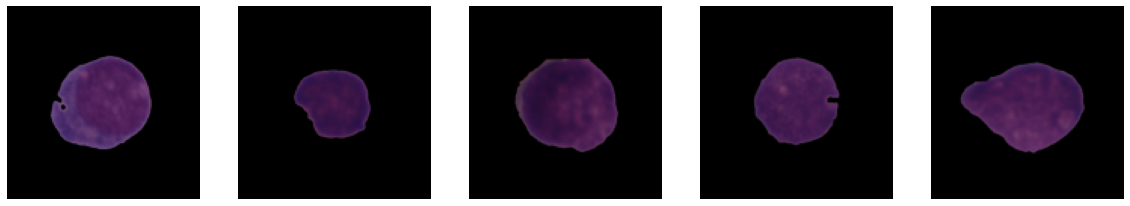

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(A))
    img  = imread(A[rand])
    img  = resize(img, (128,128))
    ax[i].imshow(img)
    ax[i].axis('off')

100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


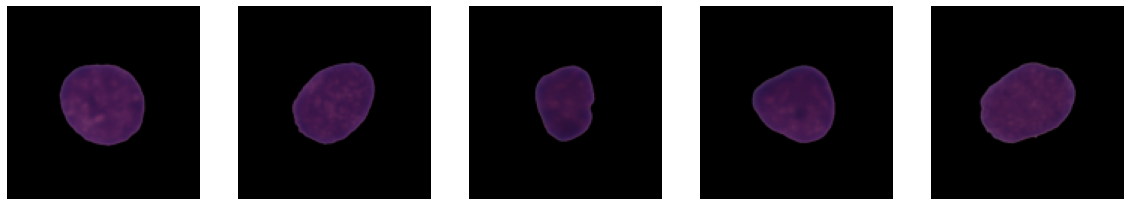

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(H))
    img  = imread(H[rand])
    img  = resize(img, (128,128))
    ax[i].imshow(img)
    ax[i].axis('off')

In [ ]:
Image = []
Label = []

for i in tqdm(range(0, len(A))):
    img = imread(A[i])
    img = resize(img, (128,128))
    Image.append(img)
    Label.append(1)
    
for i in tqdm(range(0, len(H))):
    img = imread(H[i])
    img = resize(img, (128,128))
    Image.append(img)
    Label.append(0)
    
Image = np.array(Image)
Label = np.array(Label)

Image.shape, Label.shape

  0%|          | 24/7272 [00:16<1:25:08,  1.42it/s]

In [ ]:
del A
del H

In [ ]:
# Shuffle the data as results are appened.

Image, Label = shuffle(Image, Label, random_state = 42)

100%|██████████| 5/5 [00:00<00:00, 691.10it/s]


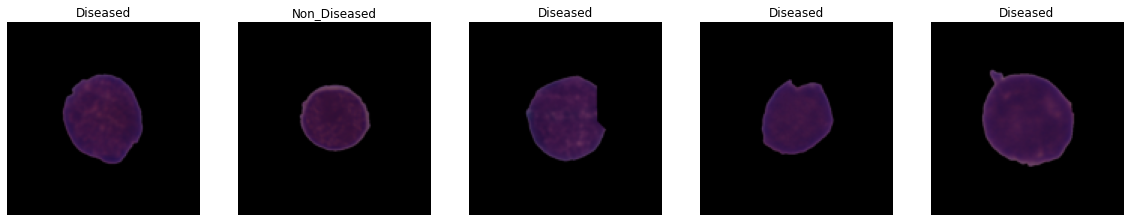

In [ ]:
# Viewing Image - After Shuffle 

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(Image))
    ax[i].imshow(Image[rand])
    ax[i].axis('off')
    a = Label[rand]
    if a == 1:
        ax[i].set_title('Diseased')
    else:
        ax[i].set_title('Non_Diseased')

In [ ]:
# Assigning Images and Label to new variable 

X = Image
y = Label

In [ ]:
del Image 
del Label

In [ ]:
valid_data.head()

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1


In [ ]:
# Checking target coloumn distribution

valid_data.labels.value_counts()

1    1219
0     648
Name: labels, dtype: int64

In [ ]:
# Loading image and storing it numpy array.

X_val = []

for image_name in valid_data.new_names:
    # Loading images
    img = imread('/content/drive/MyDrive/lukemia/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/' + image_name)
    # Resizing 
    img = resize(img, (128,128))
    # Appending them into list
    X_val.append(img)
 
# Converting into array
X_val = np.array(X_val)


# Storing target values as well 
y_val = valid_data.labels.values

In [ ]:
train_datagen  = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    zoom_range = 0.2)

train_datagen.fit(X)

In [ ]:
model = Sequential()

In [ ]:
# Input layer
model.add(InputLayer(input_shape = (128,128,3)))


# Adding layers
model.add(Conv2D(filters = 32,   kernel_size  = (3, 3), padding='valid', activation='relu'))
model.add(Conv2D(filters = 32,   kernel_size  = (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64,   kernel_size  = (3, 3), padding='valid', activation='relu'))
model.add(Conv2D(filters = 64,   kernel_size  = (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
model.add(Dropout(0.35))

model.add(Conv2D(filters = 128,  kernel_size  = (3, 3), padding='valid', activation='relu'))
model.add(Conv2D(filters = 128,  kernel_size  = (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
model.add(Dropout(0.2))


# Adding flatten
model.add(Flatten())


# Adding full connected layer (dense)
model.add(Dense(units = 512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(units = 256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))


# Adding output layer
model.add(Dense(units = 1, activation='sigmoid'))

In [ ]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 64)        1

In [ ]:
# Compile Model

model.compile(optimizer = tensorflow.keras.optimizers.Adam(1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
# Defining callbacks

filepath = '/content/drive/MyDrive/lukemia/models/best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'accuracy', 
                              mode = 'max' , 
                              patience = 10)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callback_list = [earlystopping, checkpoint]

In [ ]:
model.fit(train_datagen.flow(X, y, batch_size = 512),
          validation_data = (X_val, y_val),
          epochs = 10,
          verbose = 1,
          callbacks = callback_list)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.8015 - accuracy: 0.5995
Epoch 1: accuracy improved from -inf to 0.59947, saving model to /content/drive/MyDrive/lukemia/models/best_weights.hdf5
21/21 [==============================] - 67s 2s/step - loss: 0.8015 - accuracy: 0.5995 - val_loss: 0.9516 - val_accuracy: 0.3471
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.7465 - accuracy: 0.6494
Epoch 2: accuracy improved from 0.59947 to 0.64938, saving model to /content/drive/MyDrive/lukemia/models/best_weights.hdf5
21/21 [==============================] - 41s 2s/step - loss: 0.7465 - accuracy: 0.6494 - val_loss: 1.3265 - val_accuracy: 0.3471
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.7395 - accuracy: 0.6446
Epoch 3: accuracy did not improve from 0.64938
21/21 [==============================] - 39s 2s/step - loss: 0.7395 - accuracy: 0.6446 - val_loss: 1.8040 - val_accuracy: 0.3471
Epoch 4/10
21/21 [=====================

In [ ]:
from keras.models import load_model
model =load_model('/content/drive/MyDrive/lukemia/models/best_weights.hdf5')


In [ ]:
model.layers[0].input_shape

(None, 128, 128, 3)

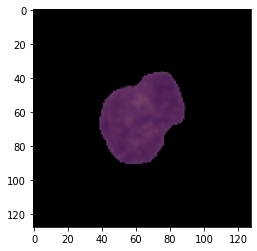

The propbility of having blood cancer is  [[0.9999945]]


In [ ]:
image_path="/content/2.bmp"
IMG_SIZE=128
from keras.preprocessing import image
img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
result=model.predict(img)
plt.show()
print("The propbility of having blood cancer is ",result)

In [ ]:
# Define Augmentation function:-
def data_augment(image, label):
    
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel = tf.random.uniform([], 0, 1.0, dtype=tf.float32)    
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    if p_pixel >= .2:
        if p_pixel >= .8:
            image = tf.image.random_saturation(image, lower=.7, upper=1.3)
        elif p_pixel >= .6:
            image = tf.image.random_contrast(image, lower=.8, upper=1.2)
        elif p_pixel >= .4:
            image = tf.image.random_brightness(image, max_delta=.1)
        else:
            image = tf.image.adjust_gamma(image, gamma=.6)
            
    if p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .4:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
        
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])
    image = tf.reshape(image, [HEIGHT, WIDTH, 3])
    
    return image, label

In [ ]:
def parse_data(filename,label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_bmp(image)
    image = tf.image.convert_image_dtype(image, tf.float32) /  0.45 
    image = tf.image.resize(image, IMAGE_SIZE)
    return image, tf.one_hot(label,2)

def load_dataset(filenames, labels ,ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False

    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(parse_data, num_parallel_calls=AUTO)
    return dataset

def get_dataset(FILENAMES,LABELS, ordered=False, repeated=False, augment=False):
    dataset = load_dataset(FILENAMES, LABELS, ordered=ordered)
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [ ]:
import math
np.set_printoptions(threshold=15, linewidth=80)
CLASSES = [0,1]

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    labels = [str(i) for i in  numpy_labels]

    return numpy_images, labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = label
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        # image = cv2.imdecode(image,cv2.IMREA)
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    
    
# Model evaluation
def plot_metrics(history):
    metric_list = [m for m in list(history.keys()) if m is not 'lr']
    size = len(metric_list)//2
    fig, axes = plt.subplots(size, 1, sharex='col', figsize=(20, size * 4))
    if size > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for index in range(len(metric_list)//2):
        metric_name = metric_list[index]
        val_metric_name = metric_list[index+size]
        axes[index].plot(history[metric_name], label='Train %s' % metric_name)
        axes[index].plot(history[val_metric_name], label='Validation %s' % metric_name)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric_name)
        if 'loss' in metric_name:
            axes[index].axvline(np.argmin(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmin(history[val_metric_name]), linestyle='dashed', color='orange')
        else:
            axes[index].axvline(np.argmax(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmax(history[val_metric_name]), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

In [ ]:
%%shell
jupyter nbconvert --to html /content/CSE3020_JCOMP.ipynb

[NbConvertApp] Converting notebook /content/CSE3020_JCOMP.ipynb to html
[NbConvertApp] Writing 988286 bytes to /content/CSE3020_JCOMP.html
